<a href="https://colab.research.google.com/github/MathiasLater/efc2/blob/main/EFC2_EX1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA048 A - Aprendizado de Máquina

---
## EFC2 - Classificação Linear e kNN

\
### Gabriel Costa Clemente R.A.: 171961
### Mathias Epstein Later R.A.: 160443

\
O objetivo deste EFC é utilizar técnicas de *Machine Learning* em problemas de classificação de padrões.

\

1.   Classificação Binária

Neste exercício, o intuito é realizar a classificação de vozes masculinas e femininas a partir de uma base de dados.

Inicialmente, realizamos um estudo sobre os atributos relacionados às amostras, gerando uma matriz de correlação e histogramas, apresentados a seguir.

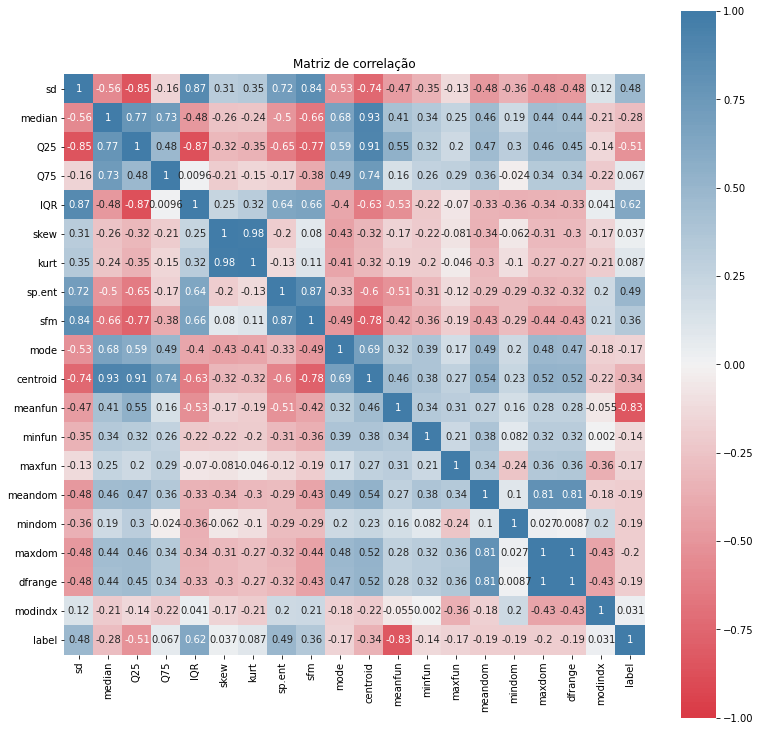

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('dados_voz_genero.csv',sep = ',') # Extração dos dados

# df_aux = pd.read_csv('dados_voz_genero.csv',sep = ',') # Extração dos dados (auxiliar)
# df_aux.pop("label") # Exclusão da coluna associada aos labels

# Matriz de correlação
corrMatrix = df.corr()

fig, ax = plt.subplots(figsize=(13,13))
hm = sn.heatmap(corrMatrix, # Heat map da matriz de correlação
                vmin=-1, vmax=1, center=0,
                cmap=sn.diverging_palette(10, 240, n=200),
                square=True, annot=True, ax=ax)
hm.set_title('Matriz de correlação')
hm.set_autoscale_on
plt.show()

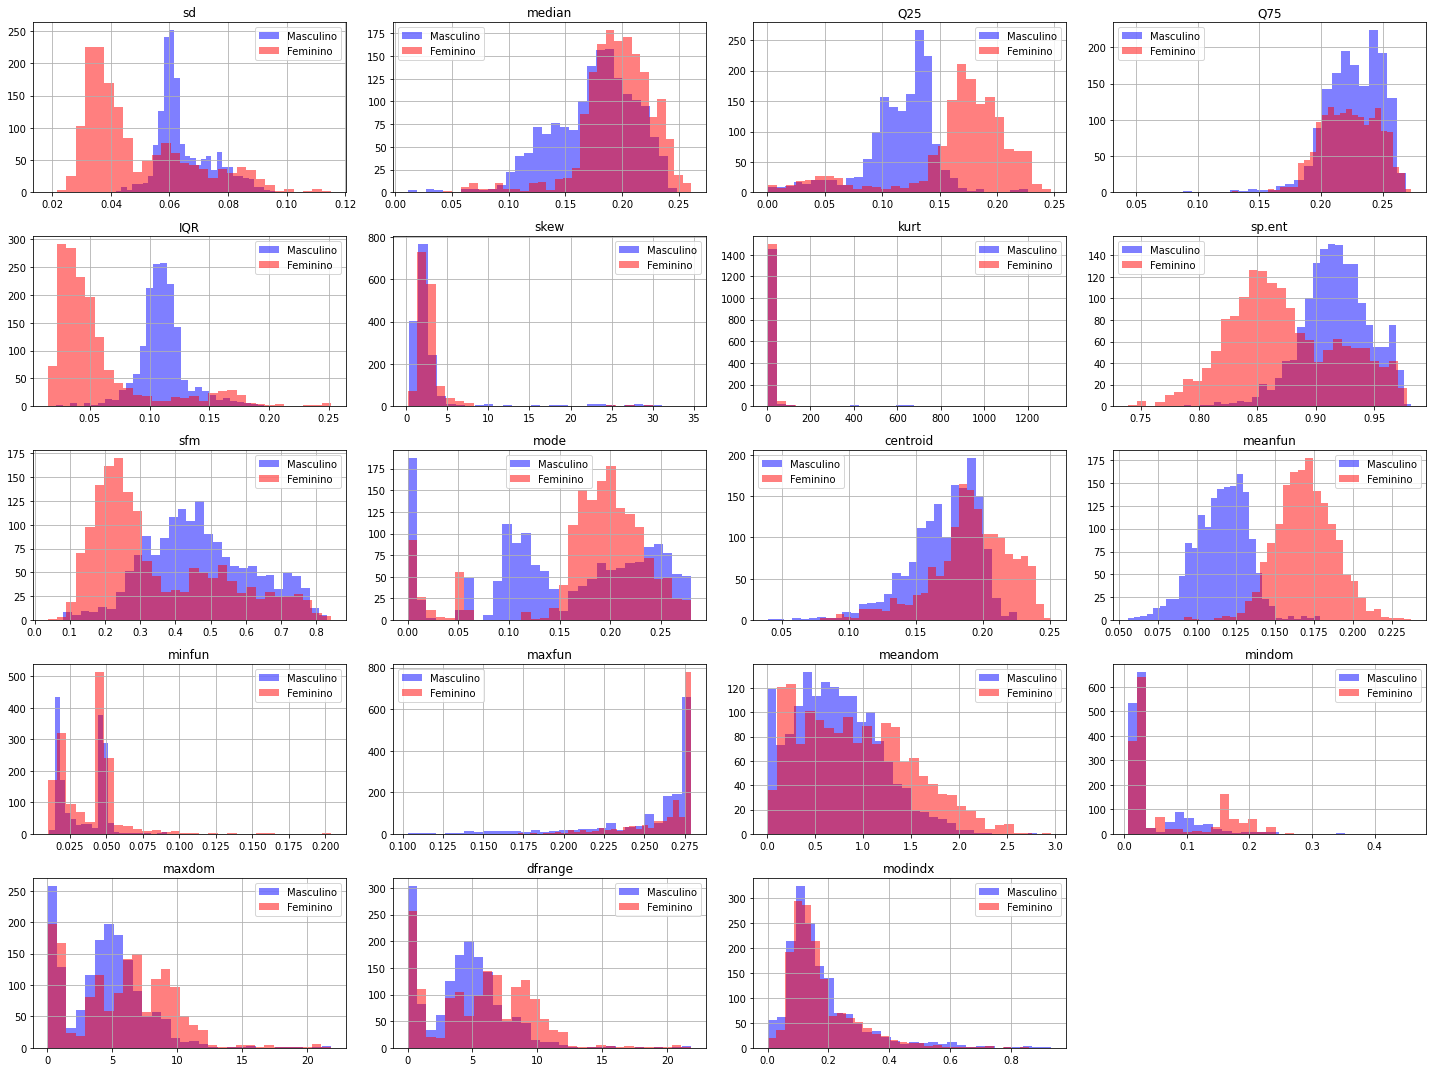

In [ ]:
# Histogramas
df_male, df_female = df[df.label == 1], df[df.label == 0]
for i in range(19):
  plt.subplot(5,4,i+1)

  df_male[df_male.columns[i]].hist(bins=30, color='blue', label='Masculino', figsize=(20,15), stacked= True, alpha=0.5)
  df_female[df_female.columns[i]].hist(bins=30, color='red', label='Feminino', figsize=(20,15), stacked= True, alpha=0.5)

  plt.legend()
  plt.tight_layout()
  plt.title(df_male.columns[i])

A partir da matriz de correlação plotada, podemos fazer algumas observações interessantes. Vemos que as características que possuem maior correlação com os rótulos são aquelas que demonstram uma divisão mais clara entre os dados associados aos gêneros masculino e feminimo. Por exemplo, **IQR** e **meanfun** são atributos muito importantes para o modelo de classificação.

Os histogramas que apresentam distribuição semelhante para os gêneros são aqueles que têm menor correlação com o rótulo, o que é coerente, visto que tais atributos dão menos informação para a classificação das amostras.

\

Analisando os histogramas, observamos que alguns atributos apresentam ordens de grandeza consideravelmente maiores que outros. Os modelos de classificação implementados a partir das funções do *scikitlearn* assumem que todos os atributos estão centrados em zero e com variância na mesma ordem de grandeza. Caso os dados não sejam escalados corretamente, o potencial de aprendizagem do modelo a partir de todos os atributos será prejudicado, uma vez que aqueles com valores grandes dominarão a função custo a ser minimizada (o atributo **dfrange**, por exemplo, não é tão relevante para a classificação, porém, quando comparado aos outros, apresenta valores muito grandes, sendo assim, caso não fosse escalado, resultaria em um modelo que aprende menos com o restante dos atributos). Desse modo, é necessário realizar um escalamento prévio dos dados.   

\
O pré-processamento e o treinamento do modelo são realizados a seguir para diferentes valores de *threshold*. Em seguida, plotamos o gráfico da F1-medida em função do *threshold* utilizado. 

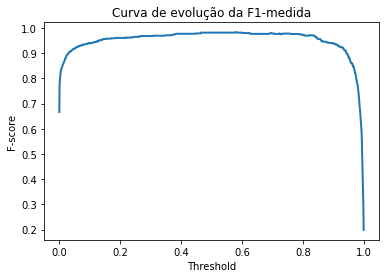



Melhor threshold:  0.577
Melhor F1-medida:  0.9827856025039122


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn import preprocessing

# Prepara as matrizes de dados normalizados (x) e de rótulos (y)
x = df.drop('label',axis = 1)
x = preprocessing.scale(x)
y = df.label

# Separa as matrizes x e y em conjuntos de treinamento e de validação
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

# Cria e treina o modelo de regressão logística a partir dos conjuntos de treinamento
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

# Realiza as predições das probabilidades de cada grupo de padrões do conjunto de dados de teste pertencer à classe 1 (masculina)
y_scores = model.predict_proba(x_test)
y_scores = y_scores[:,1]

# Cria e calcula vetores de threshold e de fscore para thresholds de 0 a 1 com passo de 0,001
threshold = np.arange(start=0, stop=1, step=0.001)
fscore = np.zeros(len(threshold))
best_threshold = 0
best_fscore = 0
for i in range(len(threshold)):
  y_pred = (y_scores > threshold[i])
  fscore[i] = f1_score(y_test, y_pred)
  if best_fscore < fscore[i]:
    best_fscore = fscore[i]
    best_threshold = threshold[i]

# Plota a curva de evolução da F1-medida
def plot_f_score_curve(threshold, fscore, label=None):
  plt.plot(threshold, fscore, linewidth=2, label=label)
  plt.xlabel('Threshold')
  plt.ylabel('F-score')
  plt.title('Curva de evolução da F1-medida')
  plt.show()
plot_f_score_curve(threshold, fscore)

print("\n")
print("Melhor threshold: ",best_threshold)
print("Melhor F1-medida: ",best_fscore)

Utilizando a probabilidade calculada pelo modelo para a predição de cada amostra do conjunto de teste, variamos o *threshold* de 0 a 1 em passos de 0,01 e plotamos os resultados da F1-medida (ver gráfico acima).
Concluímos que apenas para valores de *threshold* muito baixos ou muito altos o modelo apresentou um desempenho ruim, o que indica uma certa facilidade do modelo em diferenciar a maior parte das amostras, atribuindo, para a maior parte delas, valores de probabilidade muito altos quando a amostra tem rótulo 1 e valores muito baixos quando tem rótulo 0.
A melhor F1-medida foi de 0,98, para um *threshold* de 0,577.

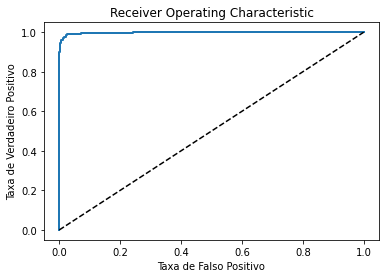



Área sob a curva ROC (AUC):  0.9978306083252892


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Faz as predições com base no melhor threshold
y_pred = (y_scores > best_threshold)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
  plt.xlabel('Taxa de Falso Positivo')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('Receiver Operating Characteristic')
  plt.show()
plot_roc_curve(fpr, tpr)

print("\n")
print("Área sob a curva ROC (AUC): ",roc_auc_score(y_test, y_scores))

A curva ROC confirma a eficiência do modelo. Mesmo para valores muito baixos de falsos positivos, temos valores elevados de *recall*. A área sobre a curva se aproxima muito de 1, ou seja, do resultado ideal.

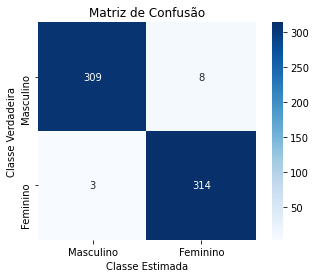

<Figure size 360x288 with 0 Axes>



Acurácia:  0.9826498422712934


In [ ]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
cm = sn.heatmap(conf_matrix, fmt='.0f', square=True, annot=True, cmap="Blues",
                xticklabels=('Masculino','Feminino'),
                yticklabels=('Masculino','Feminino'))

plt.xlabel('Classe Estimada')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.figure(figsize=(5,4))
plt.show()

model_accuracy = metrics.accuracy_score(y_test, y_pred)
print("\n")
print("Acurácia: ",model_accuracy)

Por fim, geramos a matriz de confusão e calculamos a acurácia. O modelo acertou mais de 98% das classificações, com mais falsos positivos do que falsos negativos, o que faz sentido, pois escolhemos um *threshold* maior do que 50%.

Realizamos, também, o treinamento do modelo com dados não pré-processados, para o qual obtivemos uma acurácia de 93%, além de uma curva de F1-medida muito mais dependente do *threshold*. Isso confirma o que foi discutido anteriormente a respeito da importância dessa etapa para a obtenção de um modelo eficiente.